In [1]:
#importing libraries 
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
from torch.autograd import Variable

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings('ignore')
!mkdir models

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9f25f688eabf7fbd0e6bb295cb42c9a32ae81d0b60b4e7e3b3fbc0cd019b7960
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
image_size = 256
#IMAGE PREPROCESSING

def prepare_image(path, 
                  sigmaX         = 10, 
                  do_random_crop = False):
    
    '''
    Preprocess image
    '''
    
    # import imagepre
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # perform smart crops
    image = crop_black(image, tol = 7)
    if do_random_crop == True:
        image = random_crop(image, size = (0.9, 1))
    
    # resize and color
    image = cv2.resize(image, (int(image_size), int(image_size)))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
    
    # circular crop
    image = circle_crop(image, sigmaX = sigmaX)

    # convert to tensor    
    image = torch.tensor(image)
    image = image.permute(2, 1, 0)
    return image

In [3]:
#CROP FUNCTIONS

def crop_black(img, 
               tol = 7):
    
    '''
    Perform automatic crop of black areas
    '''
    
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        
        if (check_shape == 0): 
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img  = np.stack([img1, img2, img3], axis = -1)
            return img

In [4]:
def circle_crop(img, 
                sigmaX = 10):   
    
    '''
    Perform circular crop around image center
    '''
        
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness = -1)
    
    img = cv2.bitwise_and(img, img, mask = circle_img)
    return img

In [5]:
def random_crop(img, 
                size = (0.9, 1)):
    
    '''
    Random crop
    '''

    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)

    img = img[i:h, j:w, :]    
    
    return img

In [6]:
class EyeData(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.jpeg'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + self.itype)
        image    = prepare_image(img_name, do_random_crop = self.do_random_crop)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': image, 'label': label}

In [7]:
class Data(Dataset):
    
    # initialize
    def __init__(self, data, directory, transform = None, do_random_crop = True, itype = '.jpeg'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.do_random_crop = do_random_crop
        self.itype = itype
    # length
    def __len__(self):
        return len(self.data)
    
    # get items    
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.loc[idx, 'image'] + self.itype)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_black(image, tol = 7)
        image = cv2.resize(image, (int(image_size), int(image_size)))
        image = circle_crop(image, sigmaX = 10)
        image = torch.tensor(image)
        image = image.permute(2, 1, 0)
        image    = self.transform(image)
        label    = torch.tensor(self.data.loc[idx, 'level'])
        return {'image': image, 'label': label}

In [8]:
df = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
train.columns = ['image', 'level']
train = df[:28000]
test  = df[28000:]

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['level'].value_counts())
print('-' * 15)
print(test['level'].value_counts())

(28000, 2) (7126, 2)
---------------
level
0    20528
2     4256
1     1955
3      706
4      555
Name: count, dtype: int64
---------------
level
0    5282
2    1036
1     488
3     167
4     153
Name: count, dtype: int64


Text(0.5, 0, 'Diagnosis')

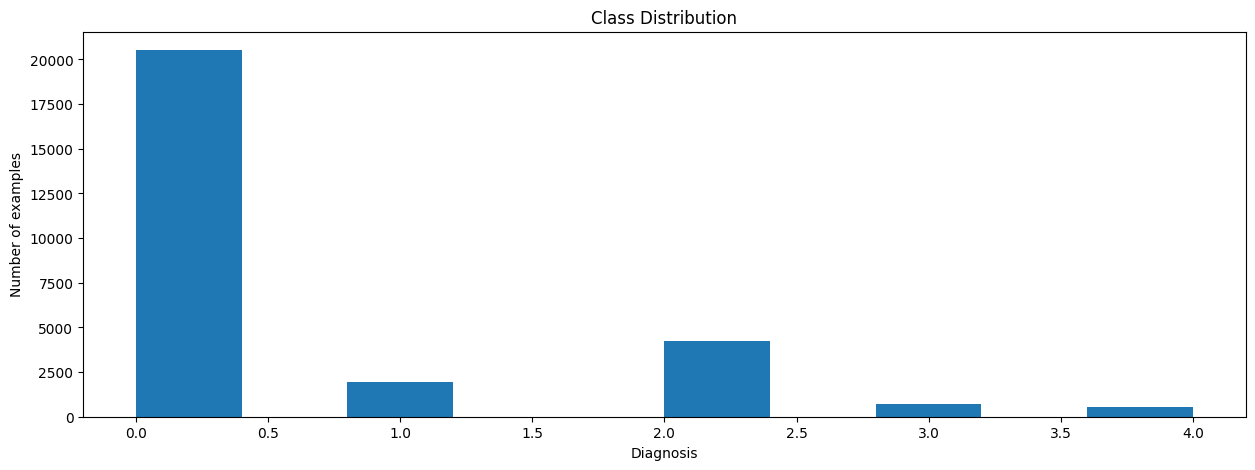

In [9]:
# CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['level'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

In [10]:
# # IMAGE SIZES

# # placeholder
# image_stats = []

# # import loop
# for index, observation in tqdm(train.iterrows(), total = len(train)):
    
#     # import image
#     img = cv2.imread('../input/diabetic-retinopathy-resized/resized_train/resized_train/{}.jpeg'.format(observation['image']))

#     # compute stats
#     height, width, channels = img.shape
#     ratio = width / height
    
#     # save
#     image_stats.append(np.array((observation['level'], height, width, channels, ratio)))

# # construct DF
# image_stats = pd.DataFrame(image_stats)
# image_stats.columns = ['level', 'height', 'width', 'channels', 'ratio']

Text(0.5, 0, 'Ratio')

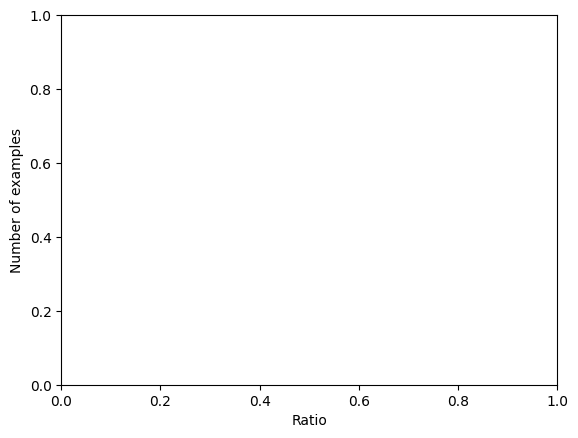

In [11]:
# # IMAGE SIZE DISTRIBUTION

# fig = plt.figure(figsize = (15, 5))

# # width
# plt.subplot(1, 3, 1)
# plt.hist(image_stats['width'])
# plt.title('(a) Image Width')
# plt.ylabel('Number of examples')
# plt.xlabel('Width')

# # height
# plt.subplot(1, 3, 2)
# plt.hist(image_stats['height'])
# plt.title('(b) Image Height')
# plt.ylabel('Number of examples')
# plt.xlabel('Height')

# # ratio
# plt.subplot(1, 3, 3)
# plt.hist(image_stats['ratio'])
# plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

In [12]:
#TRANSFORMATIONS

# parameters
batch_size = 16
image_size = 256

# train transformations
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ToTensor()
                                 ])

# validation transformations
valid_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# test transformations
test_trans = valid_trans

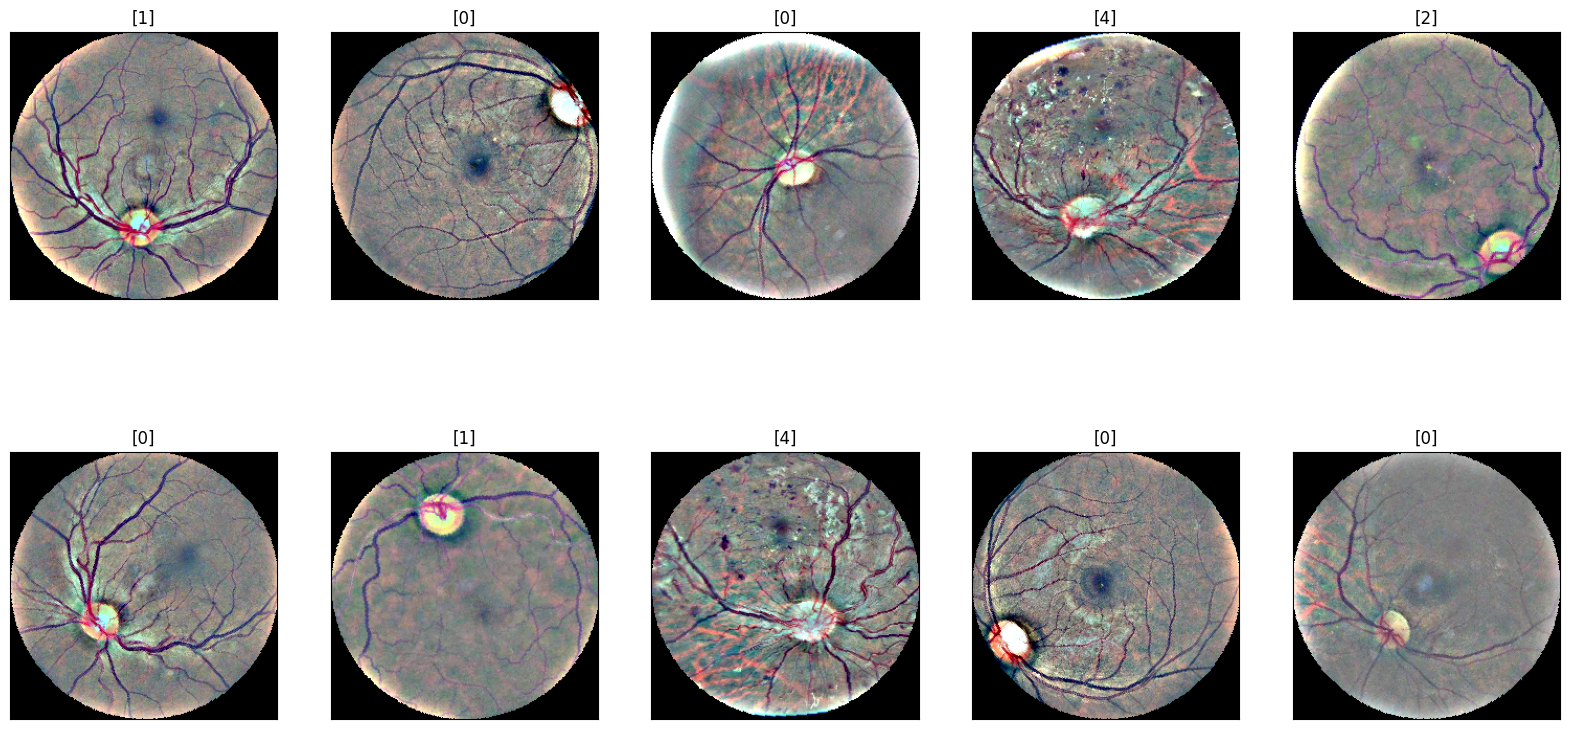

In [13]:
#EXAMINE FIRST BATCH (TRAIN)

# get dataset
sample = EyeData(data       = train.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = train_trans,
                      itype ='.jpeg')

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = True, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

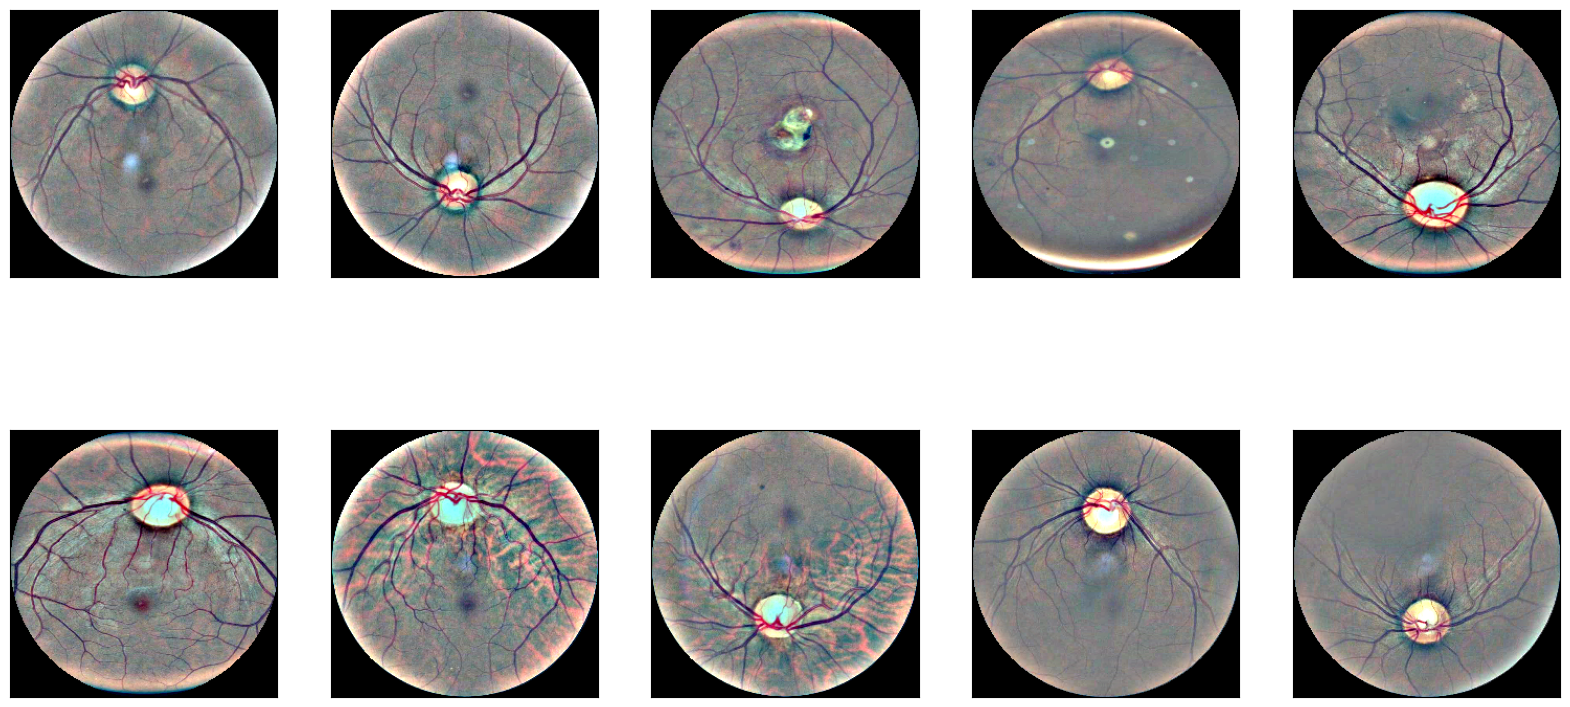

In [14]:
#EXAMINE FIRST BATCH (TEST)
test = test.reset_index()
# get dataset
sample = EyeData(data       = test.iloc[0:10], 
                      directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                      transform  = test_trans,
                      itype ='.jpeg',
                      do_random_crop = False)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = batch_size, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
 
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(10):
        ax = fig.add_subplot(2, int(10/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))

    break

In [15]:
#MODEL ARCHITECTURE

# model name
model_name = 'enet_b7'

# initialization function
def init_pre_model(train = True):
    
    '''
    Initialize the model
    '''
    
    ### training mode
    if train == True:
        
        # load pre-trained model
        model = EfficientNet.from_pretrained('efficientnet-b7', num_classes = 5)
        
    ### inference mode
    if train == False:
        
        # load pre-trained model
        model = EfficientNet.from_name('efficientnet-b7')
        model._fc = nn.Linear(model._fc.in_features, 5)

        # freeze  layers
        for param in model.parameters():
            param.requires_grad = False
            
    ### return model
    return model


# check architecture
model = init_pre_model()
print(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 266MB/s]


Loaded pretrained weights for efficientnet-b7
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, ke

In [16]:
#VALIDATION SETTINGS

# placeholders
oof_preds = np.zeros((len(test), 5))

# timer
cv_start = time.time()

In [17]:
#PARAMETERS

# loss function
criterion = nn.CrossEntropyLoss()

# epochs
max_epochs = 35###################################################
early_stop = 35

# learning rates
eta = 1e-3

# scheduler
step  = 5
gamma = 0.5

In [18]:
#DATA PREPARATION

# load splits
data_train = train
data_valid = test

# create datasets
train_dataset = EyeData(data      = data_train, 
                             directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                             transform = train_trans,
                             itype ='.jpeg')
valid_dataset = EyeData(data       = data_valid, 
                            directory  = '../input/diabetic-retinopathy-resized/resized_train/resized_train',
                            transform  = valid_trans,
                            itype ='.jpeg')

# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = True, 
                                           num_workers = 4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size  = batch_size, 
                                           shuffle     = False, 
                                           num_workers = 4)

In [19]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [20]:
#MODELING EPOCHS

# placeholders
val_kappas = []
val_losses = []
trn_losses = []
bad_epochs = 0

# initialize and send to GPU
model = init_pre_model()
model = model.to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr = eta)
scheduler = lr_scheduler.StepLR(optimizer, step_size = step, gamma = gamma)

# training and validation loop
for epoch in range(max_epochs):
    ### PREPARATION

    # timer
    epoch_start = time.time()

    # reset losses
    trn_loss = 0.0
    val_loss = 0.0

    # placeholders
    fold_preds = np.zeros((len(data_valid), 5))


    #TRAINING

    # switch regime
    model.train()

    # loop through batches
    for batch_i, data in enumerate(train_loader):

        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        # forward and backward pass
        with torch.set_grad_enabled(True):
            preds = model(inputs)
            loss  = criterion(preds, labels)
            loss.backward()
            optimizer.step()

        # compute loss
        trn_loss += loss.item() * inputs.size(0)
        
        
    #INFERENCE

    # switch regime
    model.eval()
    
    # loop through batches
    for batch_i, data in enumerate(valid_loader):
        
        # extract inputs and labels
        inputs = data['image']
        labels = data['label'].view(-1)
        inputs = inputs.to(device, dtype = torch.float)
        labels = labels.to(device, dtype = torch.long)

        # compute predictions
        with torch.set_grad_enabled(False):
            preds = model(inputs).detach()
            fold_preds[batch_i * batch_size:(batch_i + 1) * batch_size, :] = preds.cpu().numpy()

        # compute loss
        loss      = criterion(preds, labels)
        val_loss += loss.item() * inputs.size(0)
        
    # save predictions
    oof_preds = fold_preds

    # scheduler step
    scheduler.step()


    #EVALUATION

    # evaluate performance
    fold_preds_round = fold_preds.argmax(axis = 1)
    val_kappa = metrics.cohen_kappa_score(data_valid['level'], fold_preds_round.astype('int'), weights = 'quadratic')

    # save perfoirmance values
    val_kappas.append(val_kappa)
    val_losses.append(val_loss / len(data_valid))
    trn_losses.append(trn_loss / len(data_train))


    #EARLY STOPPING

    # display info
    print('- epoch {}/{} | lr = {} | trn_loss = {:.4f} | val_loss = {:.4f} | val_kappa = {:.4f} | {:.2f} min'.format(
        epoch + 1, max_epochs, scheduler.get_lr()[len(scheduler.get_lr()) - 1],
        trn_loss / len(data_train), val_loss / len(data_valid), val_kappa,
        (time.time() - epoch_start) / 60))

    # check if there is any improvement
    if epoch > 0:       
        if val_kappas[epoch] < val_kappas[epoch - bad_epochs - 1]:
            bad_epochs += 1
        else:
            bad_epochs = 0

    # save model weights if improvement
    if bad_epochs == 0:
        oof_preds_best = oof_preds.copy()
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, 'models/model_{}_checkpoint.pth.tar'.format(model_name))

    # break if early stop
    if bad_epochs == early_stop:
        print('Early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break

    # break if max epochs
    if epoch == (max_epochs - 1):
        print('Did not met early stopping. Best results: loss = {:.4f}, kappa = {:.4f} (epoch {})'.format(
            np.min(val_losses), val_kappas[np.argmin(val_losses)], np.argmin(val_losses) + 1))
        print('')
        break


# load best predictions
oof_preds = oof_preds_best

# print performance
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

Loaded pretrained weights for efficientnet-b7
- epoch 1/35 | lr = 0.001 | trn_loss = 0.7545 | val_loss = 0.7954 | val_kappa = 0.3845 | 20.35 min
- epoch 2/35 | lr = 0.001 | trn_loss = 0.6879 | val_loss = 0.6291 | val_kappa = 0.5880 | 20.21 min
- epoch 3/35 | lr = 0.001 | trn_loss = 0.6615 | val_loss = 0.6584 | val_kappa = 0.5051 | 20.23 min
- epoch 4/35 | lr = 0.001 | trn_loss = 0.6355 | val_loss = 0.5761 | val_kappa = 0.7013 | 20.21 min
- epoch 5/35 | lr = 0.00025 | trn_loss = 0.6233 | val_loss = 0.5759 | val_kappa = 0.6503 | 20.21 min
- epoch 6/35 | lr = 0.0005 | trn_loss = 0.5794 | val_loss = 0.5395 | val_kappa = 0.6899 | 20.31 min
- epoch 7/35 | lr = 0.0005 | trn_loss = 0.5650 | val_loss = 0.5194 | val_kappa = 0.7230 | 20.22 min
- epoch 8/35 | lr = 0.0005 | trn_loss = 0.5549 | val_loss = 0.5227 | val_kappa = 0.7227 | 20.20 min
- epoch 9/35 | lr = 0.0005 | trn_loss = 0.5508 | val_loss = 0.5320 | val_kappa = 0.7307 | 20.20 min
- epoch 10/35 | lr = 0.000125 | trn_loss = 0.5433 | val_l

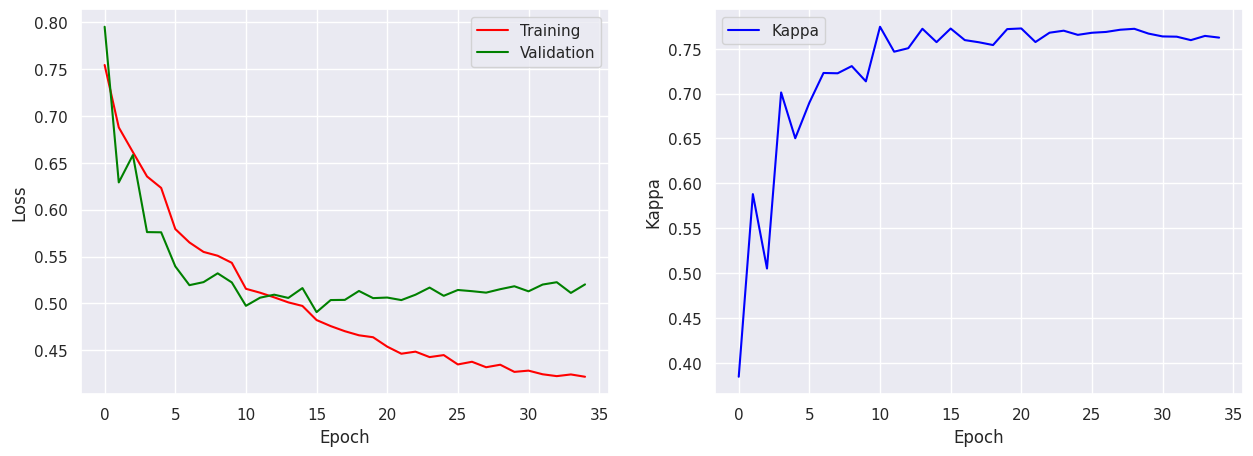

In [21]:
#PLOT LOSS AND KAPPA DYNAMICS
sns.set()
# plot size
fig = plt.figure(figsize = (15, 5))

# plot loss dynamics
plt.subplot(1, 2, 1)
plt.plot(trn_losses, 'red',   label = 'Training')
plt.plot(val_losses, 'green', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot kappa dynamics
plt.subplot(1, 2, 2)
plt.plot(val_kappas, 'blue', label = 'Kappa')
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

In [22]:
#RECHECK PERFORMANCE

# rounding
oof_preds_round = oof_preds.argmax(axis = 1)
coef = [0.5, 1.5, 2.5, 3.5]
for i, pred in enumerate(oof_preds_round):
    if pred < coef[0]:
        oof_preds_round[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        oof_preds_round[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        oof_preds_round[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        oof_preds_round[i] = 3
    else:
        oof_preds_round[i] = 4

# compute kappa
oof_loss  = criterion(torch.tensor(oof_preds), torch.tensor(test['level']).view(-1).type(torch.long))
oof_kappa = metrics.cohen_kappa_score(test['level'], oof_preds_round.astype('int'), weights = 'quadratic')
print('OOF loss  = {:.4f}'.format(oof_loss))
print('OOF kappa = {:.4f}'.format(oof_kappa))

OOF loss  = 0.4973
OOF kappa = 0.7745


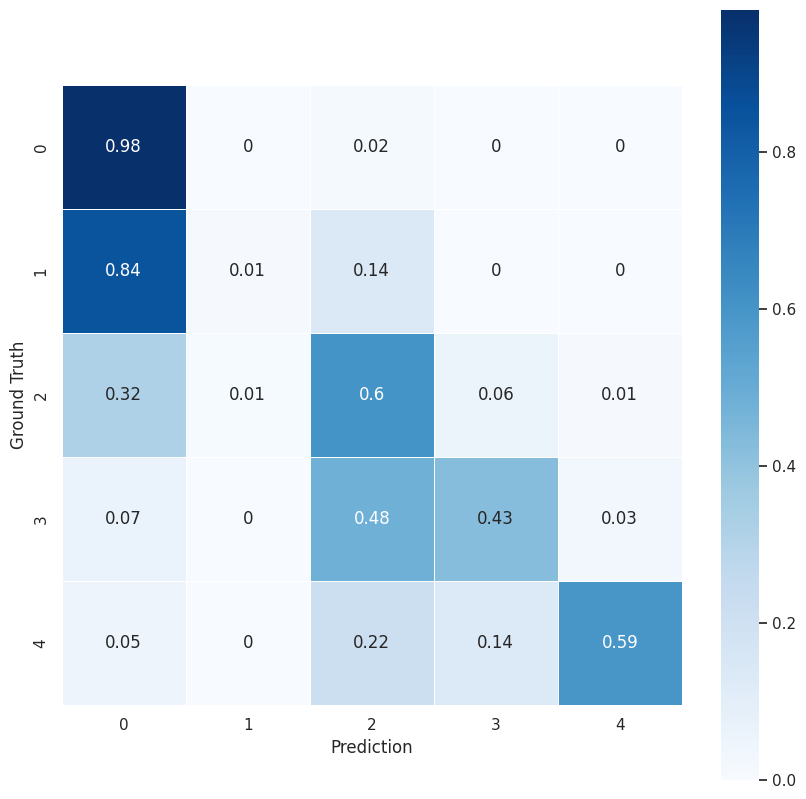

In [23]:
#CONFUSION MATRIX

# construct confusion matrix
cm = confusion_matrix(test['level'], oof_preds_round)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')

In [24]:
from sklearn.metrics import classification_report

#Classification Report Test
print('\n Classification Report in Test: \n',classification_report(test['level'], oof_preds_round))


 Classification Report in Test: 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      5282
           1       0.24      0.01      0.03       488
           2       0.70      0.60      0.65      1036
           3       0.48      0.43      0.45       167
           4       0.77      0.59      0.67       153

    accuracy                           0.84      7126
   macro avg       0.61      0.52      0.54      7126
weighted avg       0.79      0.84      0.81      7126



In [25]:
# Define transformations for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to match model input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Load the image
image_path = '/kaggle/input/random-image/DR_severe.png'
image = Image.open(image_path)

# Preprocess the image
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Pass the preprocessed image through the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    input_image = input_image.to(device)  # Move input to GPU if available
    output = model(input_image)

# Interpret the output to get predictions
predicted_class = torch.argmax(output, dim=1).item()

# Print the predicted class
print("Predicted Class:", predicted_class)

Predicted Class: 1


In [26]:
model_f = EfficientNet.from_name('efficientnet-b7')
model_f._fc = nn.Linear(model_f._fc.in_features, 5)

model_f.load_state_dict(checkpoint['model_state_dict'])

torch.save(model_f,'models/mymodel_checkpoint.pth')

In [27]:
mymodel= torch.load('models/mymodel_checkpoint.pth')

In [28]:
 mymodel.eval()

# Define transformations for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to match model input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])

# Load the image
image_path = '/kaggle/input/random-image/10fca1abf338.png'  # Change this to your image path
image = Image.open(image_path)

# Preprocess the image
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Pass the preprocessed image through the model
with torch.no_grad():
    output = mymodel(input_image)

# Interpret the output to get predictions
predicted_class = torch.argmax(output, dim=1).item()

# Print the predicted class
print("Predicted Class:", predicted_class)

Predicted Class: 1


In [29]:
# model = EfficientNet.from_name('efficientnet-b2')
# # model._fc = nn.Linear(model._fc.in_features, 5)
# model_f = EfficientNet.from_name('efficientnet-b7')
# # model_f._fc = nn.Linear(model_f._fc.in_features, 5)

#         # freeze  layers
# # for param in model_f.parameters():
# #     param.requires_grad = False

# # model_f = init_pre_model(train=False)
# model_f.load_state_dict(torch.load('models/model_enet_b7_checkpoint.pth'))
# # model.load_state_dict(torch.load('models/model_enet_b2.pth'))

# # Set the model to evaluation mode
# model_f.eval()

# # Define transformations for preprocessing the image
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize image to match model input size
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
# ])

# # Load the image
# image_path = '/kaggle/input/random-image/10fca1abf338.png'  # Change this to your image path
# image = Image.open(image_path)

# # Preprocess the image
# input_image = transform(image).unsqueeze(0)  # Add batch dimension

# # Pass the preprocessed image through the model
# with torch.no_grad():
#     output = model_f(input_image)

# # Interpret the output to get predictions
# predicted_class = torch.argmax(output, dim=1).item()

# # Print the predicted class
# print("Predicted Class:", predicted_class)